# Obtención de datos

In [ ]:
import pandas as pd
import regex
import requests
import unidecode
import os, glob
from pathlib import Path  
import cv2
import plotly.express as px
import matplotlib.pyplot as plt 
from tqdm import tqdm
import shutil, sys
import urllib.request
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk import FreqDist
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')

In [8]:
850+150

1000

In [2]:
# descargar un total de 1000 datos por clase: 80% train, 20% test
OFFSETS_TRAIN = list(range(0,700,50)) #700 datos
OFFSETS_TEST = list(range(700,850,50)) #150 datos
OFFSETS_VAL = list(range(850,1000,50)) #150 datos

In [ ]:
!pip install sklearn 

In [2]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [ ]:
!pip install opencv-python
!pip install plotly==5.10.0
!pip install pillow
!pip install regex
!pip install Unidecode
!pip install wordcloud
!pip install nltk

^C
^C


In [3]:
cats = requests.get('https://api.mercadolibre.com/sites/MLA/categories')
prod_categories= cats.json()

En total contamos con 32 categorías 

In [4]:
def obtain_json_items(json_cat,offset_input):
    offset = offset_input #FIX ME : Set variable offset [0,50,100,150]
    cat_id = json_cat['id']
    cat_name = json_cat['name']
    url = f'https://api.mercadolibre.com/sites/MLA/search?category={cat_id}&offset={offset}'
    request = requests.get(url)
    items = request.json()
    return items, cat_name

In [5]:
def obtain_json_items_iteratively(json_cat,offset_list):
    results = []
    offsets = offset_list
    cat_id = json_cat['id']
    cat_name = json_cat['name']
    for off in offsets: 
        url = f'https://api.mercadolibre.com/sites/MLA/search?category={cat_id}&offset={off}'
        request = requests.get(url)
        data = request.json()
        for element in data['results']:
            results.append(element)
    return results, cat_name

In [6]:
def get_product_brand(items_cat):
    brands = []
    for att in items_cat['attributes']:
        find_attr = att['id']
        if 'BRAND' in find_attr or 'Brand' in find_attr:
            brands.append(att['value_name'])
            break
    return brands

In [7]:
def pre_proc_nlp(text_df):
    cleaned_df =[]
    for text in text_df:
        clean_text = regex.sub(r'\&[a-z]+\;', '', text)
        clean_text = regex.sub(r"\n", " ", text)
        clean_text = text.lower()
        clean_text = regex.sub('[0-9]+', ' NUMB ', clean_text)
        clean_text = unidecode.unidecode(clean_text)
        clean_text = regex.sub(r'(NUMB\s+)(NUMB\s*)*', ' NUMB ', clean_text)
        clean_text = regex.sub(r'\s+', ' ', clean_text)
        clean_text = regex.sub('[^a-zA-Z]', ' ', clean_text).strip(' ')
        cleaned_df.append(clean_text)
    return cleaned_df

In [8]:
def clean_name(text_name):
    text = text_name
    clean_text = regex.sub(r'\&[a-z]+\;', '', text)
    clean_text = regex.sub(r"\n", " ", text)
    clean_text = text.lower()
    clean_text = unidecode.unidecode(clean_text)
    clean_text = regex.sub(r'\s+', ' ', clean_text)
    clean_text = regex.sub('[^a-zA-Z]', ' ', clean_text).strip(' ')
    cleaned_df = clean_text
    return cleaned_df

In [9]:
def encoding_categs(categories):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(categories)
    return integer_encoded

In [12]:
categories_=[]
for category in prod_categories:
    categories_.append(category['name'])
numeric_categories = encoding_categs(categories_)

In [13]:
dict_categs = dict(zip(categories_,numeric_categories))

In [68]:
def create_pd_product(item_json,item_category, num_categs):
    titles_=[]
    marcas_=[]
    image_=[]
    items = item_json
    for i in range(len(items)):
        titles_.append(items[i]['title'].lower()) 
        marcas_.append(get_product_brand(items[i])) #extraer la marca
        image_.append(items[i]['thumbnail'])
    df_products = pd.DataFrame(columns=['nombre','categoria','marca','imagen'])
    df_products['nombre'] = titles_
    df_products['categoria'] = clean_name(item_category)
    df_products['marca'] = marcas_
    df_products['imagen'] = image_
    df_products['nombre_preproc'] = pre_proc_nlp(df_products['nombre'])
    df_products['numeric_category'] = dict_categs[item_category]
    return df_products

In [69]:
category_dict_train = {}
category_dict_test = {}
category_dict_val = {}
for category in tqdm(prod_categories): 
    #obtener diccionario de elementos para train, test y val
    item_json_train,item_category_train = obtain_json_items_iteratively(category,OFFSETS_TRAIN) #train
    item_json_test,item_category_test = obtain_json_items_iteratively(category,OFFSETS_TEST) #test
    item_json_val,item_category_val = obtain_json_items_iteratively(category,OFFSETS_VAL) #test
    #train dataset 
    df_cat_prod_train = create_pd_product(item_json_train,item_category_train,numeric_categories)
    category_dict_train[df_cat_prod_train['categoria'][0]] = df_cat_prod_train
    #test dataset
    df_cat_prod_test = create_pd_product(item_json_test,item_category_test,numeric_categories)
    category_dict_test[df_cat_prod_test['categoria'][0]] = df_cat_prod_test
    #val dataset
    df_cat_prod_val = create_pd_product(item_json_val,item_category_val,numeric_categories)
    category_dict_val[df_cat_prod_val['categoria'][0]] = df_cat_prod_val

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [11:56<00:00, 22.38s/it]


In [65]:
def download_images(image_route, category,name_folder):
    for ind,img_url in enumerate(image_route):
        url = img_url
        file_name = category + str(ind) +'.jpg' 
        save_path = './images_'+name_folder+'/'+ category
        # Check whether the specified path exists or not
        isExist = os.path.exists(save_path)
        if not isExist:
          # Create a new directory because it does not exist 
          os.makedirs(save_path)
        completeName = os.path.join(save_path, file_name)
        if len(url)>0:
            urllib.request.urlretrieve(url, completeName)
        else: 
            print(ind,category)
            print(url)
            print("problema con url")

In [61]:
# Download images
for cat_ in tqdm(category_dict_train.keys()):
    download_images(category_dict_train[cat_]['imagen'],cat_,'train')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [13:22<00:00, 25.09s/it]


In [66]:
for cat_ in tqdm(category_dict_test.keys()):
    download_images(category_dict_test[cat_]['imagen'],cat_,'test') 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [03:18<00:00,  6.19s/it]


In [63]:
for cat_ in tqdm(category_dict_val.keys()):
    download_images(category_dict_val[cat_]['imagen'],cat_,'val')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [03:20<00:00,  6.27s/it]


# Generate whole dataset 

In [70]:
df_dataset_train = pd.concat([category_dict_train[cat] for cat in category_dict_train], axis=0)
df_dataset_test = pd.concat([category_dict_test[cat] for cat in category_dict_test], axis=0)
df_dataset_val = pd.concat([category_dict_val[cat] for cat in category_dict_val], axis=0)
cwd = os.getcwd()
filepath = Path(cwd+'/dataset_train.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_dataset_train.to_csv(filepath,index=False)  

filepath = Path(cwd+'/dataset_test.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_dataset_test.to_csv(filepath,index=False)  

filepath = Path(cwd+'/dataset_val.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_dataset_val.to_csv(filepath,index=False)  

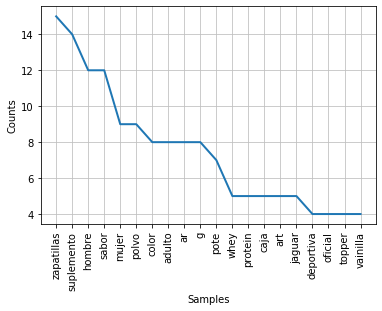

In [143]:
flat_list = [ xs for i in df_cat['nombre_preproc'] for xs in remove_stopwords(i)]
frequency_dist = FreqDist(flat_list)
frequency_dist.most_common(20)
frequency_dist.plot(20, cumulative=False)

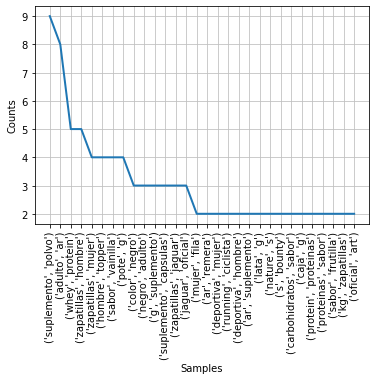

In [153]:
## Bigrams
flat_list = [ xs for i in df_cat['nombre_preproc'] for xs in remove_stopwords(i)]
text = " ".join(cat for cat in flat_list)
tokens = nltk.word_tokenize(text)
bgs = nltk.bigrams(tokens)
fdist = nltk.FreqDist(bgs)
fdist.plot(30)

Los top n-gramas muestran las sub-categorías más relevantes en la categoría general

## Tests

In [ ]:
# Dividir por características numércias, textuales y visuales para: 
# Determinar feature importance y sacar estadísticas de los datos con los que se cuenta por producto
 

In [ ]:
category_dict_train